In [2]:
import sys
print(f'Conda Env used:{sys.executable}')
print(' cell2cell_gpu_env == arboreto_gpu (in jupyter)')

Conda Env used:/home/igarzonalva/.conda/envs/cell2cell_gpu_env/bin/python
 cell2cell_gpu_env == arboreto_gpu (in jupyter)


In [4]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import numpy as np

import liana as li
import cell2cell as c2c
import decoupler as dc


import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict

import os

/home/igarzonalva/.conda/envs/cell2cell_gpu_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Paper: [Combining LIANA and Tensor-cell2cell to decipher cell-cell communication across multiple samples](https://www.cell.com/cell-reports-methods/fulltext/S2667-2375(24)00089-4)

Tutorial: [Intercellular Context Factorization with Tensor-Cell2cell](https://liana-py.readthedocs.io/en/latest/notebooks/liana_c2c.html)

In [2]:
base_dir = '/home/igarzonalva/Proyecto_SC_TNBC/GSE161529' 
os.chdir(base_dir)
adata_dir = 'LabelTransfer/adatas/general_adata_postLT.h5ad'

# Load & Prep Data

In [20]:
adata = sc.read_h5ad(adata_dir)

In [21]:
adata

AnnData object with n_obs × n_vars = 202568 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', 'leiden', 'IGA_First_GenAnno', 'scanvi_prediction', 'IGA_PostScAnvi_GenAnno_colors', 'post_lt_anno'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'IGA_PostScAnvi_GenAnno_colors_colors', 'batch_colors', 'hvg', 'leiden', 'log1p', 'majority_voting_colors', 'neighbors', 'post_lt_anno_colors', 'predicted_labels_colors', 'scanvi_prediction_colors', 'subtype_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'd

In [22]:
desired_cells = adata.obs.IGA_PostScAnvi_GenAnno_colors.isin(['Epithelial','Cycling Epithelial','Myoepithelial cells',
                                                              'Myeloid ','Fibroblast FAP+','Fibroblast FAP-', 'Mast cells', 'Endothelial'])
desired_cells

AAACCTGCAAGCGTAG-1-GSM4909281    False
AAACCTGCAATAGAGT-1-GSM4909281     True
AAACCTGCAATTGCTG-1-GSM4909281     True
AAACCTGCACTCAGGC-1-GSM4909281     True
AAACCTGCAGTGACAG-1-GSM4909281     True
                                 ...  
TTTGTTGGTGGGTATG-1-GSM4909317     True
TTTGTTGTCACTTTGT-1-GSM4909317     True
TTTGTTGTCGCACGGT-1-GSM4909317    False
TTTGTTGTCTCCCTAG-1-GSM4909317     True
TTTGTTGTCTCGGTAA-1-GSM4909317    False
Name: IGA_PostScAnvi_GenAnno_colors, Length: 202568, dtype: bool

In [23]:
adata_analysis = adata[desired_cells,:].copy()
adata_analysis

AnnData object with n_obs × n_vars = 129801 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', 'leiden', 'IGA_First_GenAnno', 'scanvi_prediction', 'IGA_PostScAnvi_GenAnno_colors', 'post_lt_anno'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'IGA_PostScAnvi_GenAnno_colors_colors', 'batch_colors', 'hvg', 'leiden', 'log1p', 'majority_voting_colors', 'neighbors', 'post_lt_anno_colors', 'predicted_labels_colors', 'scanvi_prediction_colors', 'subtype_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'd

In [38]:
adata_analysis.obs['post_lt_anno'].value_counts()

post_lt_annoV2
EC0              25478
EC1              25207
EC2              23986
EC3              22249
EC10              5622
EC12              4696
matrix_CAF        3994
EC13              3106
Endothelial       2397
iCAF              2340
EC18              2001
IDO_CAF           1467
Pericytes         1221
IGA_U2            1081
vCAF              1027
Mast cells         853
IGA_U1             778
apCAF_FAPhigh      731
EC22               701
tumor_CAF          581
IGA_U3             120
EC26                91
EC27                74
Name: count, dtype: int64

In [17]:
#fraction = 0.1
#n_cells = int(fraction * adata.n_obs)
#random_indices = np.random.choice(adata.n_obs, size=n_cells, replace=False)
#adata_sub = adata[random_indices, :].copy()

In [39]:
adata_analysis.obs['context'] = adata_analysis.obs.batch.astype(str) + adata_analysis.obs.subtype.astype(str)

In [40]:
adata_analysis.obs.context.value_counts()

context
GSM4909282TNBC         13962
GSM4909302ER            8332
GSM4909299ER            7209
GSM4909306ER            6963
GSM4909294HER2          6629
GSM4909296ER            6365
GSM4909297ER            6221
GSM4909304ER            5765
GSM4909286TNBC_BRCA     5696
GSM4909307ER            5586
GSM4909315ER            5086
GSM4909285TNBC_BRCA     5047
GSM4909293HER2          4450
GSM4909290HER2          4233
GSM4909317ER            4062
GSM4909289HER2          3730
GSM4909313ER            3659
GSM4909309ER            3361
GSM4909291HER2          3159
GSM4909301ER            3052
GSM4909287TNBC_BRCA     2727
GSM4909311ER            2610
GSM4909305ER            2507
GSM4909288TNBC_BRCA     2471
GSM4909298ER            2332
GSM4909303ER            1530
GSM4909281TNBC          1341
GSM4909300ER             953
GSM4909284TNBC           363
GSM4909292HER2           257
GSM4909283TNBC           143
Name: count, dtype: int64

In [42]:
adata_analysis.obs.subtype.value_counts()

subtype
ER           75593
HER2         22458
TNBC_BRCA    15941
TNBC         15809
Name: count, dtype: int64

In [9]:
sample_key = 'context'
condition_key = 'subtype'
groupby = 'post_lt_annoV2'

In [44]:
adata_analysis.write_h5ad('./liana/liana_adata.h5ad')

... storing 'context' as categorical


# Ligand-Receptor Inference by Sample

In [24]:
li.mt.rank_aggregate.by_sample(
    adata_analysis,
    groupby=groupby,
    resource_name='consensus', # NOTE: uses human gene symbols!
    sample_key=sample_key, # sample key by which we which to loop
    use_raw=False,
    verbose='full', # use 'full' to show all verbose information
    n_perms=None, # exclude permutations for speed
    return_all_lrs=True, # return all LR values
    )

Converting `context` to categorical!
Using resource `consensus`. 0%|                                               | 0/28 [00:00<?, ?it/s]
Using `.X`!
4341 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_Angio, Mac_IFN, Mac_LA, Mast_cells, Pericyte, Plasma cells, RTM_IM, RTM_LA, apCAF, breast_normal, cDC2_CD207, cDC2_FCER1A, cDC4_FCGR3A, cDC_LAMP3, tpCAF
0.54 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 357 samples and 701 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|█▍                                       | 1/28 [00:05<02:39,  5.92s/it]
Using `.X`!
4731 features of mat are empty, they will be removed.
The following cell identities were excluded: IDO_CAF, Mac_Hypo, Mac_Rec, Mast_cells, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, Plasma cells, RTM_IFN, RTM_IM, cDC2_AREG, cDC3_CD14, dCAF, pDC, unknown, vCAF
0.46 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 295 samples and 892 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.:   7%|██▌                                 | 2/28 [00:17<03:57,  9.13s/it]
Using `.X`!
5340 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, RTM_LA, T cells, apCAF, cDC2_AREG
0.66 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 554 samples and 452 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.:  11%|███▊                                | 3/28 [00:20<02:36,  6.27s/it]
Using `.X`!
6366 features of mat are empty, they will be removed.
The following cell identities were excluded: Mast_cells, breast_normal, cDC1_CLEC9A, cDC2_FCER1A, cDC_CXCL8, dCAF, hsp_tpCAF, vCAF
0.54 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 1640 samples and 735 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.:  14%|█████▏                              | 4/28 [01:06<08:51, 22.16s/it]
Using `.X`!
5058 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, IDO_CAF, Mac_Angio, Mac_IFN, Plasma cells, T cells, apCAF, iCAF, tpCAF, unknown
0.61 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 496 samples and 534 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC


Using resource `consensus`.C:  18%|██████▎                            | 5/28 [01:09<05:49, 15.18s/it]


Running NATMI
Running SingleCellSignalR


Using `.X`!
4379 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_Angio, Mac_IFN, Mac_LA, Mast_cells, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, RTM_LA, breast_normal, cDC1_CLEC9A, cDC2_CD207, cDC2_FCER1A, cDC3_CD14, cDC4_FCGR3A, cDC_CXCL8, dCAF, mCAF
0.45 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 554 samples and 898 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|████████▊                                | 6/28 [01:36<07:02, 19.20s/it]
Using `.X`!
9304 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, Mac_AgPres, Mac_LA, Pericyte, breast_normal, dCAF, tpCAF
0.73 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 446 samples and 335 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|██████████▎                              | 7/28 [01:38<04:48, 13.72s/it]
Using `.X`!
5914 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Mac_Angio, Mac_Hypo, Mac_LA, Mast_cells, RTM_IM, RTM_LA, breast_normal, cDC2_FCER1A, cDC_CXCL8, dCAF, iCAF
0.57 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 793 samples and 632 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.29%|███████████▏                           | 8/28 [01:47<04:02, 12.12s/it]
Using `.X`!
6408 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Mac_Hypo, Mac_IFN, Mac_Rec, MonoInter_CLEC10A, Mono_IL1B, T cells, breast_normal, cDC2_AREG, cDC2_FCER1A, cDC_CXCL8, dCAF, pDC, vCAF
0.55 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 400 samples and 698 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|█████████████▏                           | 9/28 [02:01<04:02, 12.74s/it]
Using `.X`!
5397 features of mat are empty, they will be removed.
The following cell identities were excluded: IDO_CAF, Mac_AgPres, MonoInter_CLEC10A, Mono_IL1B, Plasma cells, RTM_IM, apCAF, cDC2_AREG, cDC3_CD14, cDC_CXCL8, mCAF, unknown, vCAF
0.50 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 84 samples and 805 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|██████████████▎                         | 10/28 [02:05<02:57,  9.86s/it]
Using `.X`!
6938 features of mat are empty, they will be removed.
The following cell identities were excluded: Endothelial, Mac_AgPres, RTM_LA, apCAF, cDC2_AREG, cDC2_FCER1A, mCAF, unknown
0.69 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 557 samples and 397 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC


Now running: MH0040-LN-TNBC:  39%|█████████████▊                     | 11/28 [02:08<02:12,  7.82s/it]

Running NATMI
Running SingleCellSignalR


Using resource `consensus`.
Using `.X`!
6074 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, IDO_CAF, Mac_Angio, Mac_IFN, Mac_LA, Mast_cells, MonoInter_CLEC10A, Mono_IL1B, Plasma cells, RTM_LA, apCAF, breast_normal, cDC2_AREG, cDC2_FCER1A, cDC3_CD14, tpCAF, unknown, vCAF
0.64 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 535 samples and 501 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|█████████████████▏                      | 12/28 [02:11<01:44,  6.55s/it]
Using `.X`!
7077 features of mat are empty, they will be removed.
The following cell identities were excluded: Endothelial, Mac_Angio, Mac_IFN, Mast_cells, MonoInter_CLEC10A, Plasma cells, RTM_IM, apCAF, cDC_CXCL8
0.66 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 434 samples and 474 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.46%|█████████████████▋                    | 13/28 [02:16<01:28,  5.93s/it]
Using `.X`!
6254 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, Plasma cells, RTM_IM, RTM_LA, T cells, apCAF, breast_normal, cDC1_CLEC9A, cDC2_CD207, cDC2_FCER1A, cDC3_CD14, cDC4_FCGR3A, cDC_CXCL8, tpCAF, vCAF
0.58 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 377 samples and 624 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.50%|███████████████████                   | 14/28 [02:22<01:24,  6.03s/it]
Using `.X`!
7121 features of mat are empty, they will be removed.
The following cell identities were excluded: Endothelial, Mac_Angio, MonoInter_CLEC10A, Mono_IL1B, Plasma cells, RTM_IM, breast_normal, cDC1_CLEC9A, iCAF, mCAF, unknown, vCAF
0.60 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 28 samples and 616 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.:  54%|██████████████████▊                | 15/28 [02:25<01:05,  5.00s/it]
Using `.X`!
5164 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, IDO_CAF, Mac_AgPres, Mac_LA, Mast_cells, MonoInter_CXCL10, Mono_IL1B, Pericyte, RTM_IFN, cDC1_CLEC9A, cDC2_AREG, cDC3_CD14, cDC_LAMP3, unknown, vCAF
0.48 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 145 samples and 850 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`. 57%|█████████████████████▏               | 16/28 [02:28<00:54,  4.57s/it]
Using `.X`!
5422 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, IDO_CAF, Mac_AgPres, Mac_LA, MonoInter_CLEC10A, Pericyte, RTM_IM, RTM_LA, breast_normal, cDC2_AREG, cDC2_FCER1A, cDC_CXCL8, tpCAF
0.54 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 762 samples and 696 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|████████████████████████▎               | 17/28 [02:36<00:59,  5.40s/it]
Using `.X`!
7100 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, Mac_AgPres, Mast_cells, Pericyte, Plasma cells, cDC1_CLEC9A, cDC2_AREG, iCAF, tpCAF, vCAF
0.64 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 383 samples and 492 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.64%|████████████████████████▍             | 18/28 [02:39<00:48,  4.81s/it]
Using `.X`!
4361 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, IDO_CAF, Mac_Angio, Mac_Rec, MonoInter_CXCL10, Mono_IL1B, RTM_IM, RTM_LA, apCAF, cDC1_CLEC9A, cDC2_AREG, cDC4_FCGR3A, cDC_LAMP3, dCAF, pDC, tpCAF
0.47 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 230 samples and 852 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.68%|█████████████████████████▊            | 19/28 [02:47<00:50,  5.61s/it]
Using `.X`!
5990 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Mac_AgPres, Mac_IFN, Mac_Rec, MonoInter_CLEC10A, MonoInter_CXCL10, cDC1_CLEC9A, cDC2_AREG, cDC_CXCL8, mCAF, tpCAF
0.60 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 1476 samples and 554 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|████████████████████████████▌           | 20/28 [02:55<00:51,  6.46s/it]
Using `.X`!
4141 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_AgPres, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, Plasma cells, RTM_IM, apCAF, cDC2_AREG, cDC2_FCER1A, cDC_LAMP3, hsp_tpCAF, pDC, tpCAF, vCAF
0.45 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 228 samples and 908 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.75%|████████████████████████████▌         | 21/28 [03:03<00:47,  6.84s/it]
Using `.X`!
5351 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Mac_Angio, Mac_IFN, Mac_LA, MonoInter_CXCL10, Mono_IL1B, Pericyte, Plasma cells, RTM_LA, breast_normal, cDC2_FCER1A, cDC_CXCL8, mCAF, tpCAF, unknown, vCAF
0.60 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 470 samples and 587 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|███████████████████████████████▍        | 22/28 [03:07<00:35,  5.89s/it]
Using `.X`!
6360 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, IDO_CAF, Mac_AgPres, Mac_Angio, Mac_IFN, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, Plasma cells, apCAF, cDC2_FCER1A, cDC4_FCGR3A, mCAF, vCAF
0.67 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 578 samples and 453 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.82%|███████████████████████████████▏      | 23/28 [03:11<00:27,  5.42s/it]
Using `.X`!
5328 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Endothelial, Mac_AgPres, Mac_Angio, Mac_IFN, Mac_LA, MonoInter_CLEC10A, RTM_IFN, breast_normal, cDC_CXCL8, tpCAF, vCAF
0.59 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 633 samples and 601 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.86%|████████████████████████████████▌     | 24/28 [03:15<00:20,  5.00s/it]
Using `.X`!
5096 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_Angio, Mac_Hypo, Mac_IFN, Mac_LA, MonoInter_CLEC10A, Mono_IL1B, Pericyte, RTM_IFN, RTM_IM, RTM_LA, cDC2_CD207, cDC2_FCER1A, cDC3_CD14, cDC4_FCGR3A, cDC_CXCL8, cDC_LAMP3, tpCAF, vCAF
0.51 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 947 samples and 799 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.89%|█████████████████████████████████▉    | 25/28 [03:34<00:27,  9.14s/it]
Using `.X`!
5584 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_Angio, Mac_Hypo, Mac_LA, Mast_cells, MonoInter_CLEC10A, MonoInter_CXCL10, Pericyte, breast_normal, cDC2_AREG, cDC3_CD14, tpCAF, vCAF
0.56 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 718 samples and 682 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.%|█████████████████████████████████████▏  | 26/28 [03:45<00:19,  9.90s/it]
Using `.X`!
5374 features of mat are empty, they will be removed.
The following cell identities were excluded: Mac_AgPres, MonoInter_CLEC10A, Mono_IL1B, RTM_LA, apCAF, cDC1_CLEC9A, cDC2_FCER1A, cDC3_CD14, iCAF, mCAF, pDC, unknown
0.55 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 358 samples and 690 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Using resource `consensus`.96%|████████████████████████████████████▋ | 27/28 [03:50<00:08,  8.35s/it]
Using `.X`!
5731 features of mat are empty, they will be removed.
The following cell identities were excluded: B cells, Cycling cells, Endothelial, IDO_CAF, Mac_Hypo, Mac_IFN, Mac_Rec, Mast_cells, MonoInter_CXCL10, RTM_IM, RTM_LA, cDC2_AREG, cDC2_CD207, cDC4_FCGR3A, iCAF, pDC
0.50 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 50 samples and 823 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB
Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


Now running: SH0106-TNBC: 100%|██████████████████████████████████████| 28/28 [03:53<00:00,  8.36s/it]


Check results



In [25]:
adata_sub.uns["liana_res"].sort_values("magnitude_rank").head(10)

,context,source,target,ligand_complex,receptor_complex,lr_means,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,magnitude_rank
1513989,B1-Tum0554-TNBC,Mac_Hypo,RTM_IM,MIF,CD74_CXCR4,4.129988,16.023512,1.476322,2.131896,0.010244,0.961318,5.613071e-11
3690674,MH0176-HER2,mCAF,Mast_cells,LGALS1,CD69,3.625341,13.136650,2.697440,3.397565,0.040223,0.955348,1.295138e-10
340361,B1-MH0177-TNBC,mCAF,Mono_IL1B,COL1A1,CD44,3.875005,13.479287,3.326442,3.597834,0.013680,0.955912,1.716552e-10
2392322,MH0031-HER2,Pericyte,IDO_CAF,TIMP1,CD63,4.312468,18.325613,1.973883,2.842459,0.019016,0.960313,2.624254e-10
4175054,PM0337-HER2,Epithelial,RTM_LA,MIF,CD74_CXCR4,4.084883,15.736550,1.393957,2.011603,0.012843,0.959289,4.107793e-10
79424,AH0319-ER,tpCAF,RTM_LA,MIF,CD74_CXCR4,4.179569,16.610783,1.786582,2.519485,0.030534,0.962861,4.198203e-10
340362,B1-MH0177-TNBC,Mac_Hypo,Mono_IL1B,SPP1,CD44,3.822410,13.202061,2.317263,3.158928,0.010322,0.955472,4.768190e-10
1513990,B1-Tum0554-TNBC,Mac_Hypo,Mac_AgPres,MIF,CD74_CXCR4,4.051466,15.534555,1.425248,1.967207,0.009931,0.960738,5.051747e-10
1513991,B1-Tum0554-TNBC,tpCAF,tpCAF,TIMP1,CD63,3.971843,15.199804,2.649735,3.361107,0.017063,0.960325,8.980868e-10
340364,B1-MH0177-TNBC,mCAF,Mono_IL1B,COL1A2,CD44,3.777770,12.966761,3.200382,3.491896,0.012459,0.955088,9.345634e-10


# Building a Tensor

In [26]:
tensor = li.multi.to_tensor_c2c(adata_sub,
                                sample_key=sample_key,
                                score_key='magnitude_rank', # can be any score from liana
                                how='outer_cells' # how to join the samples
                                )

100%|████████████████████████████████████████████████████████████████| 28/28 [00:45<00:00,  1.63s/it]


In [28]:
tensor.tensor.shape

(28, 149, 37, 37)

Build Metadata

In [29]:
context_dict = adata_sub.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict) # add unkown to missing keys

In [35]:
tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

# Running Tensor-cell2cell

In [38]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                    tensor_meta,
                                                    copy_tensor=True, # Whether to output a new tensor or modifying the original
                                                    rank=6, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
                                                    tf_optimization='regular', # To define how robust we want the analysis to be.
                                                    random_state=0, # Random seed for reproducibility
                                                    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                    elbow_metric='error', # Metric to use in the elbow analysis.
                                                    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
                                                    upper_rank=20, # Max number of factors to try in the elbow analysis
                                                    tf_init='random', # Initialization method of the tensor factorization
                                                    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
                                                    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
                                                    sample_col='Element', # Columns containing the elements in the tensor metadata
                                                    group_col='Category', # Columns containing the major groups in the tensor metadata
                                                    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.
                                                    )

Running Tensor Factorization


# Load results from HPC

## Load adata

In [5]:
adata_analysis = sc.read_h5ad('/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/liana_data/liana_adata.h5ad')

In [8]:
adata_analysis

AnnData object with n_obs × n_vars = 129801 × 22788
    obs: 'batch', 'subtype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'complexity', 'n_genes', 'n_counts', 'predicted_labels', 'over_clustering', 'majority_voting', 'doublet_score', 'predicted_doublet', 'leiden', 'IGA_First_GenAnno', 'scanvi_prediction', 'IGA_PostScAnvi_GenAnno_colors', 'post_lt_anno', 'post_lt_annoV2', 'context'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'IGA_PostScAnvi_GenAnno_colors_colors', 'batch_colors', 'hvg', 'leiden', 'log1p', 'majority_voting_colors', 'neighbors', 'post_lt_anno_colors', 'predicted_labels_colors', 'scanvi_prediction_colors', 'subtype_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
 

## Load *li.multi.to_tensor_c2c* TENSOR

In [6]:
import pickle

with open('/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/liana_data/initial_tensor.pkl', 'rb') as f:
    initial_tensor = pickle.load(f)

In [10]:
context_dict = adata_analysis.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict) # add unkown to missing keys

In [11]:
tensor_meta = c2c.tensor.generate_tensor_metadata(interaction_tensor=initial_tensor,
                                                  metadata_dicts=[context_dict, None, None, None],
                                                  fill_with_order_elements=True
                                                  )

## Load *c2c.analysis.run_tensor_cell2cell_pipeline* TENSOR

In [14]:
import pickle

with open('/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/liana_data/cell2cell_tensor.pkl', 'rb') as f:
    tensor = pickle.load(f)

In [21]:
tensor.factors

OrderedDict([('Contexts',
                                   Factor 1  Factor 2  Factor 3  Factor 4      Factor 5  \
              GSM4909281TNBC       0.206304  0.208060  0.207203  0.138600  1.824111e-01   
              GSM4909282TNBC       0.196896  0.174801  0.181319  0.170170  1.785673e-01   
              GSM4909283TNBC       0.143472  0.206233  0.162201  0.168533  1.129039e-01   
              GSM4909284TNBC       0.145326  0.191385  0.172878  0.224766  1.181712e-01   
              GSM4909285TNBC_BRCA  0.189416  0.121015  0.168994  0.166971  1.548169e-01   
              GSM4909286TNBC_BRCA  0.100413  0.239212  0.183398  0.099409  2.576001e-01   
              GSM4909287TNBC_BRCA  0.241929  0.276253  0.248842  0.141915  2.149328e-01   
              GSM4909288TNBC_BRCA  0.198710  0.275916  0.222461  0.186412  1.890983e-01   
              GSM4909289HER2       0.246170  0.165427  0.229984  0.202196  2.282863e-01   
              GSM4909290HER2       0.226561  0.145862  0.199638 

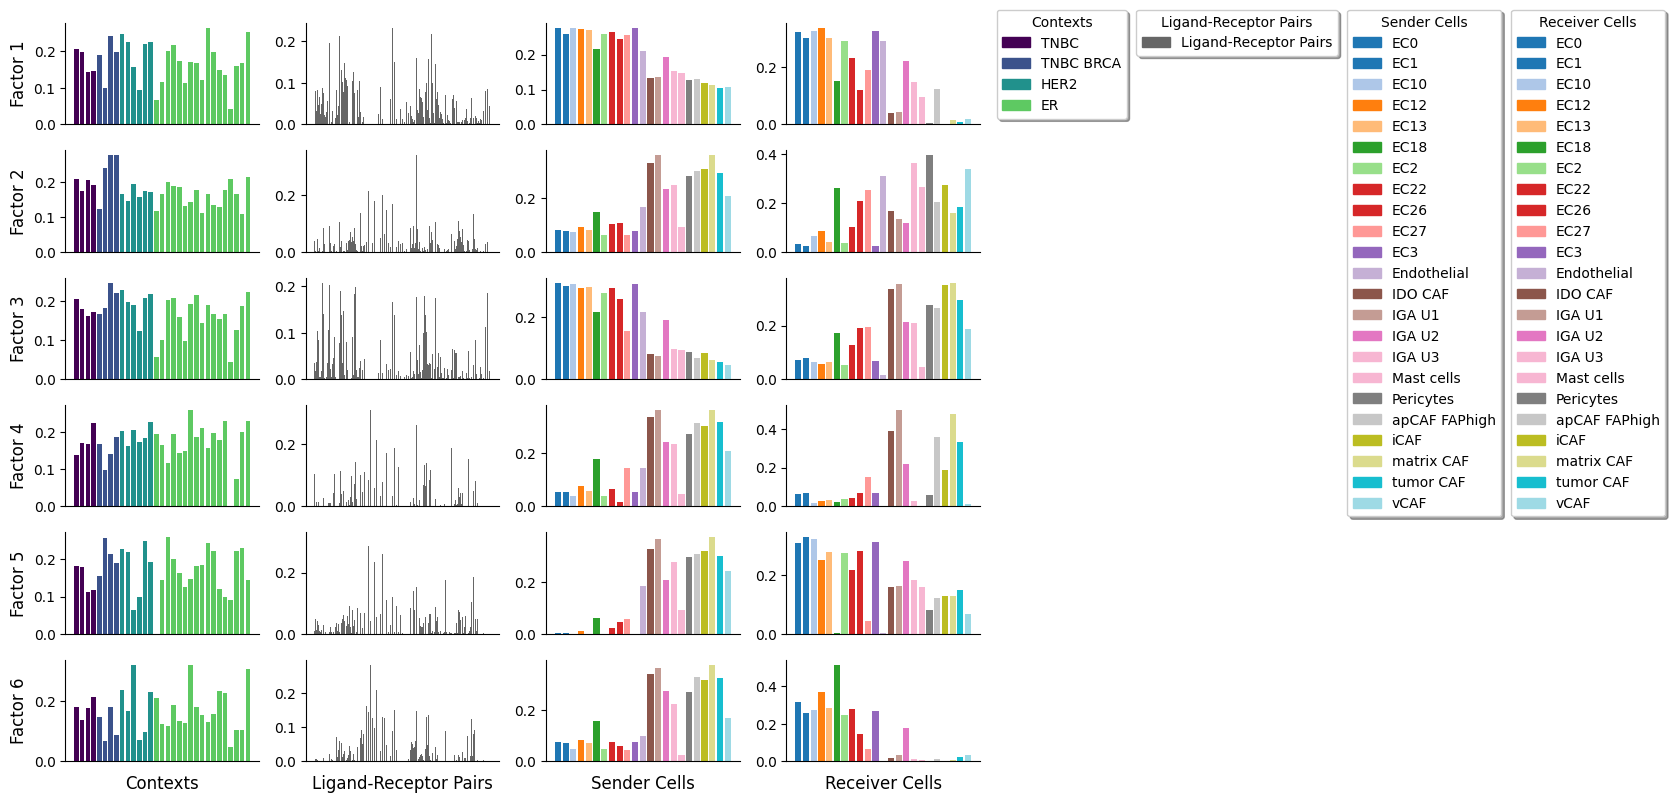

In [9]:
factors, axes = c2c.plotting.tensor_factors_plot(interaction_tensor=tensor,
                                                 metadata = tensor_meta, # This is the metadata for each dimension
                                                 sample_col='Element',
                                                 group_col='Category',
                                                 meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
                                                 fontsize=10, # Font size of the figures generated
                                                 )

# Factorization Results

Each factor gets 4 vectors, one per dimension of the 4D tensor
In factors the loadings (weights assigned) of the decomposition are stored, e.g, for each dimension (contexts, LR pair, Sender Cells, Receiver cells), how much does each individual contribute to the factor itself

In [10]:
factors = tensor.factors

In [11]:
factors.keys()

odict_keys(['Contexts', 'Ligand-Receptor Pairs', 'Sender Cells', 'Receiver Cells'])

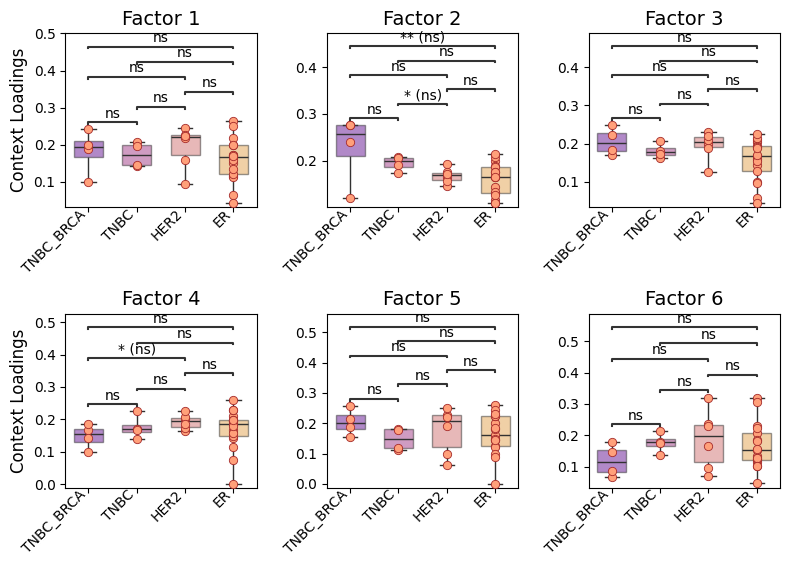

In [12]:
_ = c2c.plotting.context_boxplot(context_loadings=factors['Contexts'],
                                 metadict=context_dict,
                                 nrows=2,
                                 figsize=(8, 6),
                                 statistical_test='t-test_ind',
                                 pval_correction='fdr_bh',
                                 cmap='plasma',
                                 verbose=False,
                                )


(<Figure size 800x800 with 1 Axes>, <Axes: title={'center': 'Factor 2'}>)

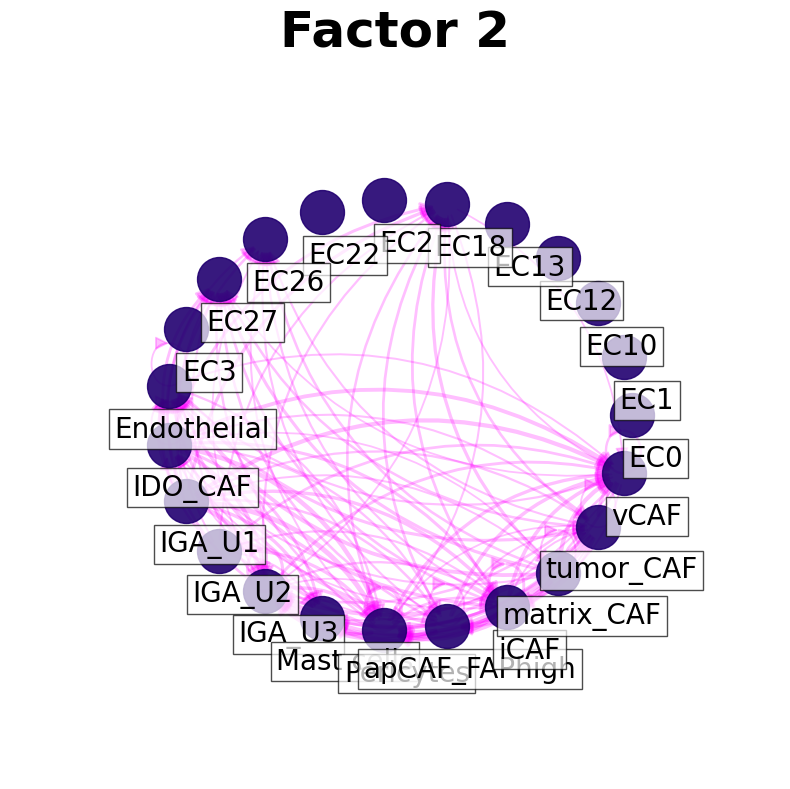

In [23]:
c2c.plotting.ccc_networks_plot(factors,
                               included_factors=['Factor 2'],
                               network_layout='circular',
                               ccc_threshold=0.05, # Only important communication
                               nrows=1,
                               panel_size=(8, 8), # This changes the size of each figure panel.
                              )


In [18]:
lr_loadings = factors['Ligand-Receptor Pairs']

In [19]:
lr_loadings

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
A2M^LRP1,2.101211e-13,3.806006e-02,0.034768,1.027029e-01,8.914878e-03,5.024849e-12
ACTR2^LDLR,8.058073e-02,3.982830e-03,0.018013,1.320205e-04,4.707027e-02,6.121779e-03
ADAM10^AXL,3.271194e-15,2.661996e-02,0.093629,1.805283e-02,2.250097e-05,6.177700e-12
ADAM10^CADM1,3.261923e-02,1.200395e-08,0.037729,1.394228e-02,1.302262e-02,4.820991e-03
ADAM10^CD44,8.197808e-02,4.324412e-02,0.103487,2.089367e-04,4.063415e-02,2.866915e-03
...,...,...,...,...,...,...
VEGFA^ITGB1,8.467466e-02,3.513187e-02,0.186121,1.730659e-05,1.815700e-05,1.047160e-04
VIM^CD44,8.537623e-02,2.308596e-01,0.087350,5.165424e-02,3.154990e-01,5.698307e-02
YBX1^NOTCH1,5.566441e-02,6.962688e-02,0.006811,2.049859e-09,4.226883e-05,2.362837e-06
ZG16B^CXCR4,4.456231e-02,1.854537e-08,0.018461,5.971032e-21,1.834377e-24,1.526534e-18


In [25]:
factors['Contexts']

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6
GSM4909281TNBC,0.206304,0.208060,0.207203,0.138600,1.824111e-01,0.178685
GSM4909282TNBC,0.196896,0.174801,0.181319,0.170170,1.785673e-01,0.135737
GSM4909283TNBC,0.143472,0.206233,0.162201,0.168533,1.129039e-01,0.175515
GSM4909284TNBC,0.145326,0.191385,0.172878,0.224766,1.181712e-01,0.212197
GSM4909285TNBC_BRCA,0.189416,0.121015,0.168994,0.166971,1.548169e-01,0.145177
GSM4909286TNBC_BRCA,0.100413,0.239212,0.183398,0.099409,2.576001e-01,0.065560
GSM4909287TNBC_BRCA,0.241929,0.276253,0.248842,0.141915,2.149328e-01,0.179727
GSM4909288TNBC_BRCA,0.198710,0.275916,0.222461,0.186412,1.890983e-01,0.087196
GSM4909289HER2,0.246170,0.165427,0.229984,0.202196,2.282863e-01,0.236157
GSM4909290HER2,0.226561,0.145862,0.199638,0.163002,2.196200e-01,0.164852


# Downstream Analysis

In [13]:
# load PROGENy pathways
net = dc.get_progeny(organism='human', top=5000)

In [14]:
net.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [15]:
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [16]:
lr_pairs.head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


In [17]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
lr_progeny.head()

,source,interaction,weight
60,JAK-STAT,LGALS9^PTPRC,1.307807
844,JAK-STAT,LGALS9^CD47,2.054778
1130,Trail,LGALS9^PTPRK,0.937003
1432,JAK-STAT,LGALS9^HAVCR2,1.487678
1779,EGFR,DLL1^NOTCH1,-1.000584


In [20]:
# run enrichment analysis
estimate, pvals = dc.run_ulm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

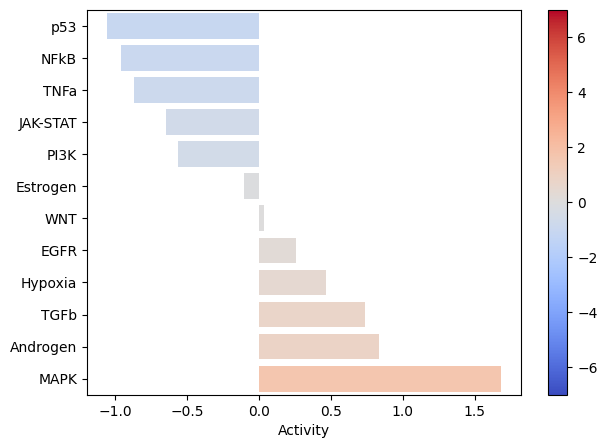

In [22]:
dc.plot_barplot(estimate, 'Factor 2', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)